In [1]:
%load_ext autoreload
%autoreload 2

## Initialisation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from LogGabor import LogGabor
import torch
from torchvision import datasets, transforms
import os
import noise
import MotionClouds as mc

In [3]:
from Where import *

Loading accuracy... min, max= 0.0145 0.9852


In [4]:
def randomized_perlin_noise(shape=(128,128), scale=10, octaves=6, persistence=0.5, lacunarity=2.0, base=0):
    noise_vector = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_vector[i][j] = noise.pnoise2(i/scale,
                                        j/scale,
                                        octaves=int(octaves * abs(np.random.randn()))+1,
                                        persistence=persistence * abs(np.random.randn()),
                                        lacunarity=lacunarity * abs(np.random.randn()),
                                        repeatx=shape[0], 
                                        repeaty=shape[1], 
                                        base=base)           

    return noise_vector

In [5]:
i_offset, j_offset = 15, 15

### MNIST_28

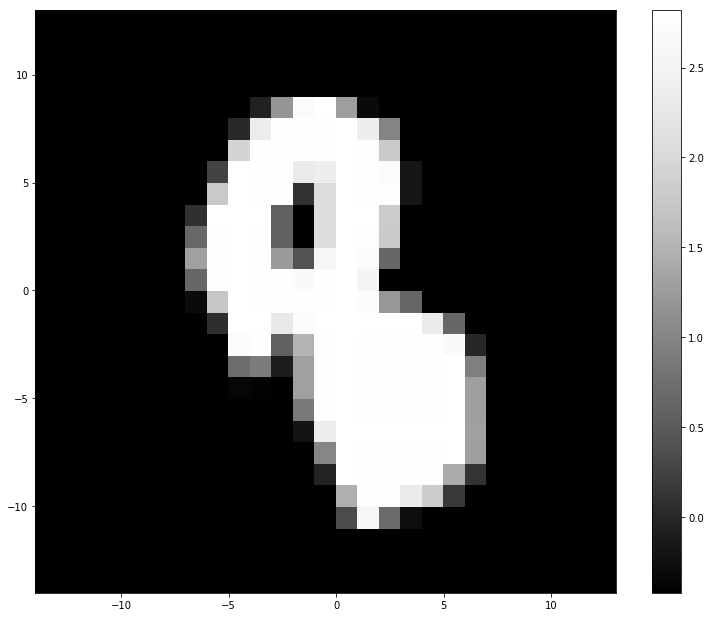

In [6]:
path = 'MNIST_28.pdf'
N_pic = 28
for batch_idx, (data, target) in enumerate(data_loader):
    data_28 = data[-1][-1]
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(data_28), cmap='Greys_r')
    fig.colorbar(cmap)
    #plt.savefig(path)
    break

### MNIST_128

(<Figure size 936x772.2 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114723c18>)

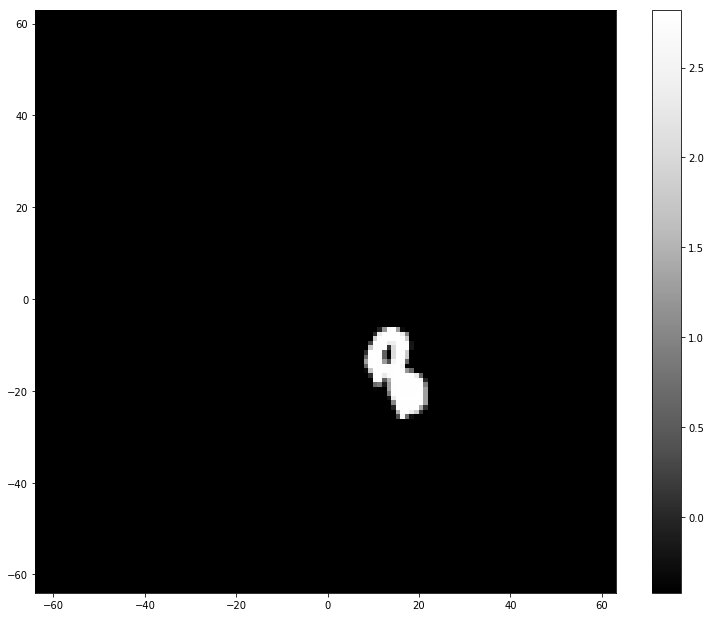

In [7]:
mnist_fullfield(data_28, i_offset, j_offset, figure_type='128')

### Bruit perlin

TypeError: Dimensions of C (128, 128) are incompatible with X (28) and/or Y (28); see help(pcolor)

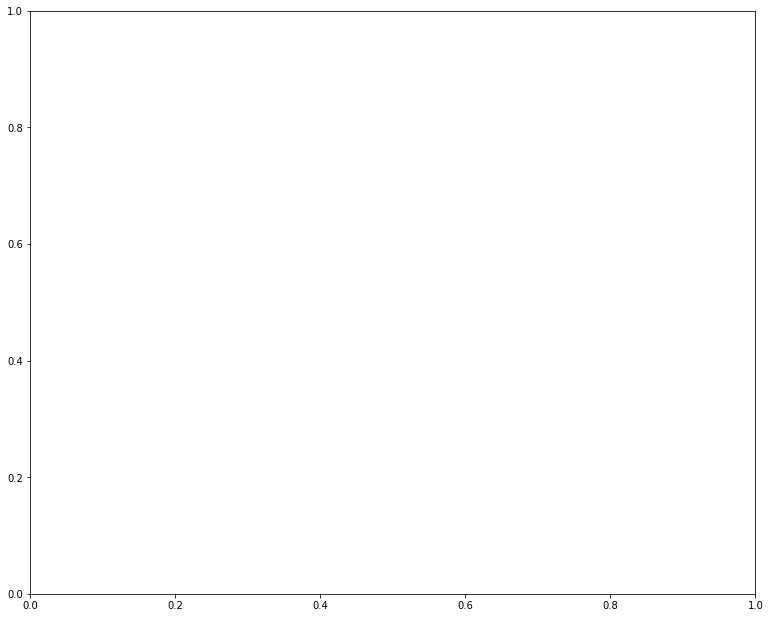

In [8]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), randomized_perlin_noise())
fig.colorbar(cmap)

### Bruit MotionCloud

In [ ]:
MotionCloudNoise(figure_type='cmap')

### Filtre LogPol classique

In [ ]:
vectorization(figure_type='retina')

### Filtre LogPol classique + image

In [ ]:
mnist_fullfield(data_28, i_offset, j_offset, figure_type='cmap')

### Filtre LogPol classique + image + bruit perlin

In [ ]:
mnist_128(i_offset,j_offset, noise=True, noise_type='Perlin')

### Filtre LogPol classique + image + bruit MotionCloud

In [ ]:
mnist_fullfield(data_28, i_offset, j_offset, noise=1., figure_type='cmap')
#plt.savefig('mnist_128_LP_MotionCloud.pdf')

### Filtre LogPolaire + image + MotionCloud (méthode alternative de déplacement de MNIST au sein de l'image)

In [ ]:
mnist_128_meth2(i_offset, j_offset)

### Filtre LogPol + orientations moyennées

In [ ]:
"""
colliculus = (retina**2).sum(axis=(0,3)) 
colliculus /= colliculus.sum(axis=-1)[:, :, None]
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
colliculus_inverse = np.linalg.pinv(colliculus_vector)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_azimuth in range(N_azimuth):
    for i_eccentricity in range(N_eccentricity):
        env = np.sqrt(colliculus[i_azimuth, i_eccentricity, :]**2.5).reshape((N_X, N_Y))
        ax.contour(colliculus[i_azimuth, i_eccentricity, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
"""
vectorization(figure_type='colliculus')
#plt.savefig('logpol_energy_filter.pdf')

### Filtre LogPol + orientations moyennées + accuracy

In [ ]:
accuracy_fullfield(accuracy, i_offset, j_offset, figure_type='colliculus')

### Couples

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

N_pic = 28
for batch_idx, (data, target) in enumerate(data_loader):
    data_28 = data[-1][-1]
    cmap = ax1.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(data_28), cmap='Greys_r')
    fig.colorbar(cmap)
    break

N_stim = data_28.shape[0]
N_pic = 128
center = (N_pic-N_stim)//2
data_fullfield = (data_28.min().numpy()) * np.ones((N_pic, N_pic))
data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data_28
cmap = ax2.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(data_fullfield), cmap='Greys_r')

N_stim = accuracy.shape[0]
center = (N_pic-N_stim)//2
accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = accuracy
cmap = ax3.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(accuracy_fullfield), cmap='Greys_r')

plt.savefig('couples_a-v.pdf')

### LogPolar view

In [ ]:
mnist_128(i_offset,j_offset, noise=False, figure_type='log')
plt.savefig('mnist_log_nonoise.pdf')

### LogPolar view + noise

In [ ]:
mnist_128(i_offset, j_offset, figure_type='log')
plt.savefig('mnist_log_motioncloud.pdf')